Eggplant analysis


      tables  iteration  org_cards  org_penalties  best_cards  best_penalties  \
0          2          0    29897.0        29942.0     29897.0         29942.0   
1          2          1    39453.0        59290.0     39453.0         59290.0   
2          2          2       45.0           49.0        45.0            49.0   
3          2          3    94422.0        94428.0     94422.0         94428.0   
4          2          4    58955.0        58986.0     58955.0         58986.0   
...      ...        ...        ...            ...         ...             ...   
1495      16         95   874006.0      1215034.0    517137.0        819129.0   
1496      16         96  1332901.0      1618126.0    735103.0       1012026.0   
1497      16         97  1203725.0      1664018.0    847547.0       1252255.0   
1498      16         98  1325461.0      1711793.0    686214.0        996611.0   
1499      16         99   544277.0       661460.0    269841.0        386922.0   

      card_imp  penalty_imp

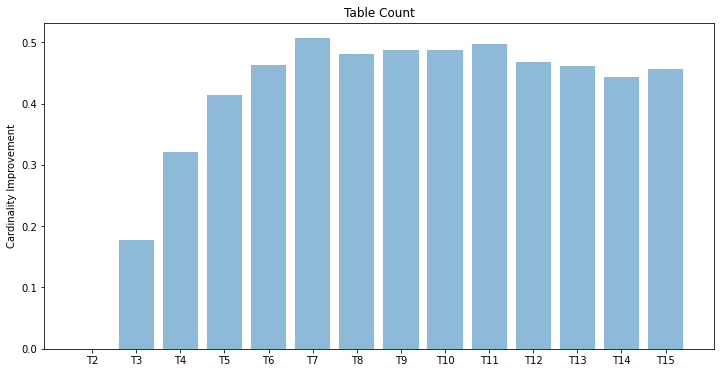

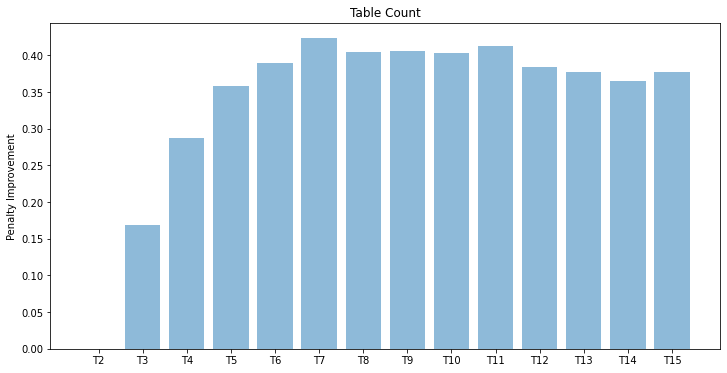

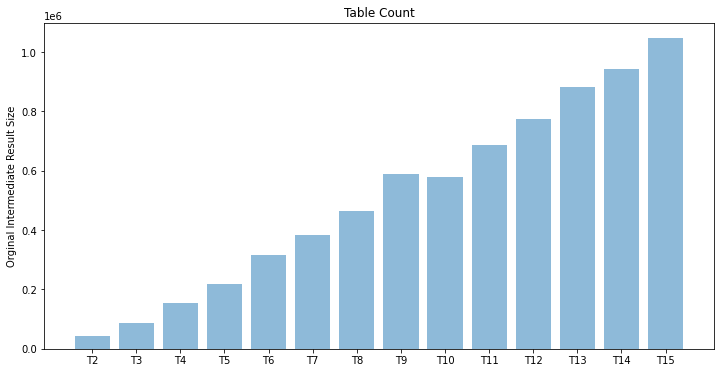

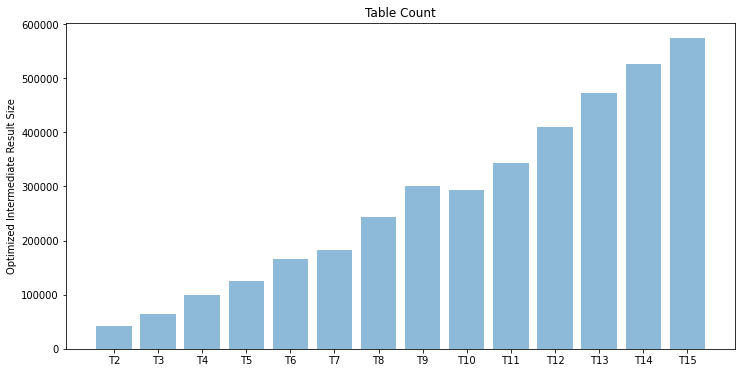

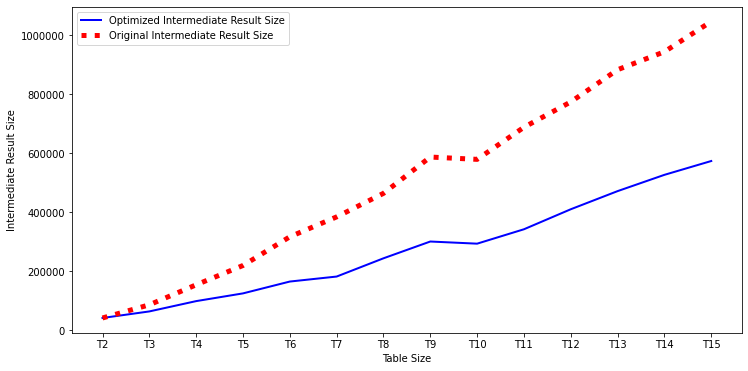

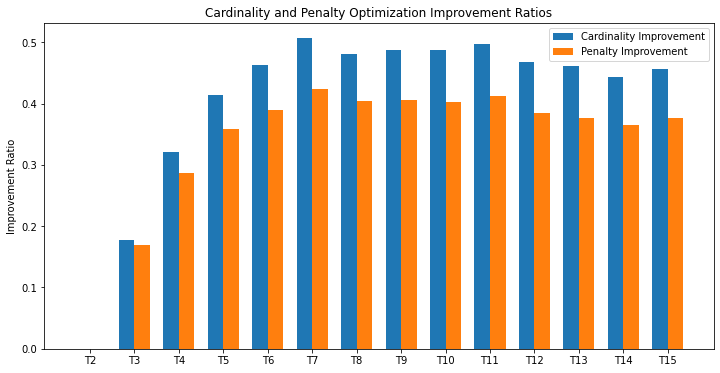

In [30]:
# Note: Copy the eggplant executable into the same direction as this notebook before running
import random
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Eggplant analysis")

join_operations = ['hashJoin', 'mergeJoin', 'nestedLoopsJoin']
access_method = ['seek', 'scan']

MAX_TABLES = 17
ITERATIONS_PER_SIZE = 100 

class TableMetric:
    def __init__(self, name, cardinality, rows, index, ordered):
        self.name = name
        self.cardinality = cardinality
        self.rows = rows
        self.index = index
        self.ordered = ordered


def build_plan_str(output, tbl_cnt, next_id):
    cur_table = 0
    output += " ("
    output += random.choice(join_operations)

    if tbl_cnt == 2:
        output += " (" + random.choice(access_method)
        output += " tbl" + str(next_id) + ")"
        next_id += 1
        output += " (" + random.choice(access_method)
        output += " tbl" + str(next_id) + ")"
        next_id += 1
    else:
        output += " (" + random.choice(access_method)
        output += " tbl" + str(next_id) + ")"
        next_id += 1
        output = build_plan_str(output, tbl_cnt - 1, next_id)

    output += ")"
    return output


def build_table_metrics(tbl_cnt):
    metrics = []
    primary_index = random.randint(1, tbl_cnt)
    for i in range(1, tbl_cnt + 1):
        name = "tbl" + str(i)

        if random.randint(0, 1) == 0:
            cardinality = random.randint(0, 75)
        else:
            cardinality = random.randint(0, 100000)

        rows = random.randint(cardinality, cardinality * random.randint(2, 4))
        if i == primary_index:
            index = "primary"
        else:
            index = "foreign"
        ordered = random.randint(0, 3) == 0
        metric = TableMetric(name, cardinality, rows, index, ordered)
        metrics.append(metric)
    return metrics


def generate_input_file(expression, metrics):
    output = '{\n'
    output += ' "expression": "' + expression + '",\n'
    output += ' "tables": [\n'
    for i in range(0, len(metrics)):

        output += '  {\n'
        output += '   "name": "' + metrics[i].name + '",\n'
        output += '   "cardinality": ' + str(metrics[i].cardinality) + ',\n'
        output += '   "rows": ' + str(metrics[i].rows) + ',\n'
        output += '   "index": "' + str(metrics[i].index) + '",\n'
        if metrics[i].ordered:
            output += '   "ordered": true\n'
        else:
            output += '   "ordered": false\n'

        if i == len(metrics) - 1:
            output += '  }\n'
        else:
            output += '  },\n'

    output += ' ]\n'
    output += '}\n'
    return output


def run_eggplant(json_file):
    child = subprocess.Popen(['eggplant', json_file], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    proc_output = child.stdout.read()
    output_lines = proc_output.splitlines()

    org_card = 0
    org_penalty = 0
    best_card = 0
    best_penalty = 0

    for line in output_lines:
        if bytes("org_card=".encode() in line):
             org_card = float(line[9:])
        elif bytes("org_penalty=".encode() in line):
            org_penalty = float(line[12:])
        elif "best_card=".encode() in line:
            best_card = float(line[10:])
        elif "best_penalty=".encode() in line:
            best_penalty = float(line[13:])

    data = {'org_card': org_card,
            'org_penalty': org_penalty,
            'best_card': best_card,
            'best_penalty': best_penalty }
    return data

def plot_results(results):
    avg_card_imp = []
    avg_penalty_imp = []
    avg_org_card = []
    avg_best_card = []

    avg_labels = []

    table_cnt = df['tables'].max()
    for table_id in range(2, table_cnt):
        tables_i = df['tables'] == table_id
        avg_card_imp.append(np.average(df[tables_i]['card_imp']))
        avg_penalty_imp.append(np.average(df[tables_i]['penalty_imp']))
        avg_org_card.append(np.average(df[tables_i]['org_cards']))
        avg_best_card.append(np.average(df[tables_i]['best_cards']))
        avg_labels.append('T' + str(table_id))

    y_pos = np.arange(len(avg_card_imp))
    fig = plt.figure(figsize=(12, 6))
    plt.bar(y_pos, avg_card_imp, align='center', alpha=0.5)
    plt.xticks(y_pos, avg_labels)
    plt.ylabel('Cardinality Improvement')
    plt.title('Table Count')
    #plt.tight_layout()
    plt.show()

    y_pos = np.arange(len(avg_penalty_imp))
    fig = plt.figure(figsize=(12, 6))
    plt.bar(y_pos, avg_penalty_imp, align='center', alpha=0.5)
    plt.xticks(y_pos, avg_labels)
    plt.ylabel('Penalty Improvement')
    plt.title('Table Count')
    plt.show()

    _pos = np.arange(len(avg_org_card))
    fig = plt.figure(figsize=(12, 6))
    plt.bar(y_pos, avg_org_card, align='center', alpha=0.5)
    plt.xticks(y_pos, avg_labels)
    plt.ylabel('Orginal Intermediate Result Size')
    plt.title('Table Count')
    plt.show()

    _pos = np.arange(len(avg_best_card))
    fig = plt.figure(figsize=(12, 6))
    plt.bar(y_pos, avg_best_card, align='center', alpha=0.5)
    plt.xticks(y_pos, avg_labels)
    plt.ylabel('Optimized Intermediate Result Size')
    plt.title('Table Count')
    plt.show()

    t_space = range(2, len(avg_best_card) + 2) #np.linspace(2, MAX_TABLES, 1001)
    fig, axes = plt.subplots(1, 1, figsize=(12, 6))
    axes.plot(t_space, avg_best_card, 'b', label="Optimized Intermediate Result Size", linewidth=2)
    axes.plot(t_space, avg_org_card, 'r', label="Original Intermediate Result Size", linestyle=':', linewidth=5)
    axes.set_xlabel("Table Size")
    axes.set_ylabel("Intermediate Result Size")
    axes.ticklabel_format(style='plain')
    plt.xticks(t_space, avg_labels)    
    axes.legend()

    x = np.arange(2, len(avg_labels) + 2)
    width = 0.35
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    rects1 = ax.bar(x - width / 2, avg_card_imp, width, label='Cardinality Improvement')
    rects2 = ax.bar(x + width / 2, avg_penalty_imp, width, label='Penalty Improvement')

    ax.set_ylabel('Improvement Ratio')
    ax.set_title('Cardinality and Penalty Optimization Improvement Ratios')
    ax.set_xticks(t_space)
    ax.set_xticklabels(avg_labels)
    ax.legend()


# run eggplant on random query plan expressions and metadata for various table counts
org_cards = []
org_penalties = []
best_cards = []
best_penalties = []
card_imp = []
penalty_imp = []
table_cnt = []
iteration = []

for i in range(2, MAX_TABLES):
    num_tables = i
    for j in range(0, ITERATIONS_PER_SIZE):
        query_string = "(select"
        query_string = build_plan_str(query_string, num_tables, 1)
        query_string += ")"

        table_metrics = build_table_metrics(num_tables)
        input_file = generate_input_file(query_string, table_metrics)

        file_name = 'input' + str(num_tables) + '.json'
        json_file = open(file_name, 'w')
        json_file.write(input_file)
        json_file.close()

        results = run_eggplant(file_name)

        org_cards.append(results['org_card'])
        org_penalties.append(results['org_penalty'])
        best_cards.append(results['best_card'])
        best_penalties.append(results['best_penalty'])

        if results['org_card'] != 0:
            card_imp.append(1.0 - (results['best_card'] / results['org_card']))
        else:
            card_imp.append(0)

        if results['org_penalty'] != 0:
            penalty_imp.append(1.0 - (results['best_penalty'] / results['org_penalty']))
        else:
            penalty_imp.append(0)

        table_cnt.append(i)
        iteration.append(j)

data = {'tables': table_cnt,
        'iteration': iteration,
        'org_cards': org_cards,
        'org_penalties': org_penalties,
        'best_cards': best_cards,
        'best_penalties': best_penalties,
        'card_imp': card_imp,
        'penalty_imp': penalty_imp }

df = pd.DataFrame(data)

print(df)

plot_results(df)

